$$
\phi_{i, j}^{k+1}=\frac{1}{4}\left(\phi_{i-1, j}^{k+1}+\phi_{i, j-1}^{k+1}+\phi_{i+1, j}^{k}+\phi_{i, j+1}^{k}\right)-\frac{1}{4} b_{i, j}
$$

Here, $\phi$ represents the pressure $P_{i,j}$, and 
$$
b_{i,j} = \Delta x^2 \frac{\rho_0}{\Delta t} \left(\frac{\partial u^{**}}{\partial x} +  \frac{\partial v^{**}}{\partial y} \right)_{i,j}
$$

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

In [2]:
import numpy as np
from numba import jit

@jit(nopython=True)
def test_SOR_solver(b, Pleft, Pright, Pprev=None, w=1, atol=1e-4, maxit=1000000):
    """
    Solve the elliptic pressure equation (formally identical to te Poisson eq.):
    ΔP = b (Δ is normalized 2D Laplace operator discretized using centered
    finite differences. Note that (dx)² is included in b.
    The algorithm usese the SOR method seen in the lectures.
    The BCs are chosen such that P=0 at the right boundary and V.Neumann
    conditions an all other boundaries.

    """

    N,M = b.shape
    is_convergent=True

    # if the pressure field at the previous iteration is not too different,
    # the algorithm might converge faster
    if Pprev is None:
        Pact = np.zeros((N,M)) # intial guess
    else:
        Pact = np.copy(Pprev)

    # the convergence condition (maybe another metric is better/more efficient)
    def converged(V0, V1):
        return np.mean(np.abs(V0-V1)) < atol

    def dP_BC(i,j):
        """
        Returns the quantites dP and b taking into account boundary conditions
        """
        _b = 0
        dP = 0

        # to test the 2D Poisson situation we used these BCs:
        if i==N-1:
            dP = 4 * Pright
        elif i==0:
            dP = 4 * Pleft
            
        # Neumann at other borders:
        elif j==0:
            dP = 4 * Pact[i,j+1]
        elif j==M-1:
            dP = 4 * Pact[i,j-1]
        else:
            dP = Pact[i-1,j] + Pact[i,j-1] + Pact[i+1,j] + Pact[i,j+1]
            _b = b[i,j]
        return dP, _b

    n = 0
    while True:
        Pold = np.copy(Pact) # needed to check the convergence

        """arguments: w between 0 and 2
        Return x a vector of the same size of a"""

        "Verifying that the inputs are correct"
        assert w > 0 and w < 2 , "the argument is not between 0 and 2"

        for i in range(N):
            for j in range(M):
                dP, _b = dP_BC(i,j)
                Pact[i,j] = (1-w) * Pact[i,j] + w * (1/4 * dP - 1/4 * _b)

        if converged(Pold, Pact):
            break
        if n > maxit:
            print('did not converge within the maximum number of iterations')
            is_convergent = False
            break
        n += 1
    return Pact,is_convergent

In [3]:
%reload_ext autoreload

In [36]:
%autoreload 1
from scipy.constants import epsilon_0

"""Mesh parameters"""
L = 100.
N = 200
M = 100

k = .1
X, dx = np.linspace(0, L, N, retstep=True)
Y, dy = np.linspace(0, L, M, retstep=True)

b = np.cos(k * X)
b = np.reshape(b, (N, 1))
b = b.repeat(M, axis=1)

phi_anal = -1/k**2 * b

In [37]:
phi, _ = test_SOR_solver(b * dx**2, phi_anal[0,0], phi_anal[-1,0], w=1.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
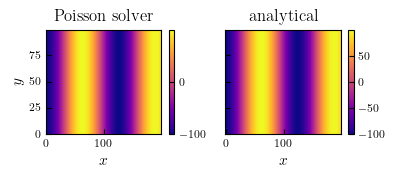

In [40]:
from plotting import set_size
plt.style.use('../tex.mplstyle')
figsize = set_size(fraction=0.65, aspect_r=0.3)

fig, [ax, ax2] = plt.subplots(1,2, sharex=True, sharey=True, figsize=figsize)
im = ax.imshow(phi.T, origin='lower', cmap='plasma', aspect='auto')
im2 = ax2.imshow(phi_anal.T, origin='lower', cmap='plasma', aspect='auto')
cbar = fig.colorbar(im2, ax=ax2)
cbar2 = fig.colorbar(im, ax=ax)
ax.set_title('Poisson solver')
ax2.set_title('analytical')
for a in [ax, ax2]:
    a.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.tight_layout()

In [41]:
#fig.savefig('../figures/poisson_test_image.svg')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
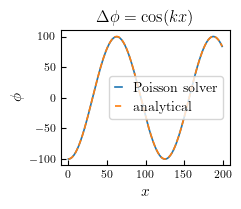

In [43]:
from plotting import set_size
plt.style.use('../tex.mplstyle')
figsize = set_size(fraction=0.4, aspect_r=0.35)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(phi[:,0], label='Poisson solver')
ax.plot(phi_anal[:,0], label='analytical', ls='--')
ax.legend(handlelength=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$\phi$')
ax.set_title('$\Delta \phi = \cos(k x)$')
plt.tight_layout()

In [44]:
#fig.savefig('../figures/poisson_test_graph.svg')

In [18]:
from Funcs import metric_RMS
import time

In [28]:
def spatial_scaling(N_list):
    
    L2 = np.zeros(len(N_list))
    Chrono = np.zeros_like(L2)
    
    for i, N in enumerate(N_list):
        
        """Mesh parameters"""
        L = 100.
        N = 200
        M = 10

        k = .1
        X, dx = np.linspace(0, L, N, retstep=True)
        Y, dy = np.linspace(0, L, M, retstep=True)

        b = np.cos(k * X)
        b = np.reshape(b, (N, 1))
        b = b.repeat(M, axis=1)

        phi_anal = -1/k**2 * b
        
        phi = np.zeros((N,M))
        t0 = time.time()
        phi, _ = test_SOR_solver(b * dx**2, phi_anal[0,0], phi_anal[-1,0], w=1.5, atol=1e-7)
        Chrono[i] = time.time() - t0
        
        L2[i] = metric_RMS(phi, phi_anal) / phi_anal.max()
    return L2, Chrono
        
N_list = 30 * np.logspace(0,5,6, base=1.5)      

In [29]:
L2, Chrono = spatial_scaling(N_list)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
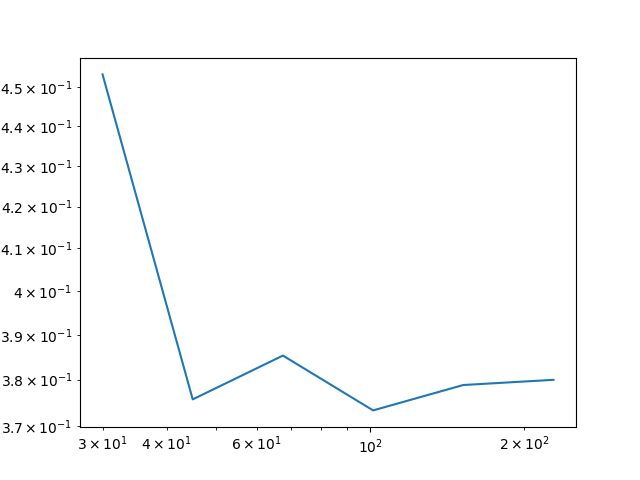

In [30]:
fig, ax = plt.subplots()
ax.plot(N_list, Chrono)
ax.set_yscale('log')
ax.set_xscale('log')
